# 4- Explore Trade networks
Notebook to visualise the trade network of a product and year.

- Nodes: They reprsent the countries. They are labelled using the 'ISO-2' code of the country and have 2 attributes: Country name ('name') and map coordinates ('pos').
- Edges: Weighted directed links representing trade between countries. 

In [1]:
import pandas as pd
import numpy as np
import time
import networkx as nx
import geopandas as gpd #pip installed
import matplotlib.pyplot as plt 

In [17]:
# Parameters to explore
year= '2019-2021'# 2018
unit = 'tonnes'
product = 'Apples' 
key_wanted = tuple([product, unit])

In [18]:
# Load Data
data = pd.read_pickle('../Data/Data_year_groups_12.pkl')

#data = pd.read_pickle('../Data/Trade_geo.pkl')
country_metadata = pd.read_pickle('../Data/Country_info.pkl')
shape_file = pd.read_pickle('../Data/Shapefile_with_positions.pkl')
data
#country_metadata = pd.read_csv('../Data/Country_info.csv',encoding="utf-8",index_col=0, na_values=[''],keep_default_na=False, dtype={'pos':'tuple'}).reset_index()
#country_metadata2=country_metadata.apply(lambda x: ast.literal_eval(x['pos']),axis=1)
#shape_file = gpd.read_file('../Data/Shapefile_with_positions.geojson',index=False)

,index,destin_country_ISO,origin_country_ISO,item,year,unit,value,origin_country,destin_country
0,0,KW,NZ,Apples,1986-1988,tonnes,64.00,New Zealand,Kuwait
1,1,KW,NZ,Apples,1986-1988,1000 US$,36.00,New Zealand,Kuwait
2,2,KW,IT,Apples,1986-1988,tonnes,68.00,Italy,Kuwait
3,4,KW,IT,Apples,1986-1988,1000 US$,39.00,Italy,Kuwait
4,6,KW,SY,Apples,1986-1988,tonnes,149.00,Syrian Arab Republic,Kuwait
...,...,...,...,...,...,...,...,...,...
14312560,29267157,DE,GT,"Cane sugar, non-centrifugal",2019-2021,1000 US$,4.00,Guatemala,Germany
14312561,29267159,FR,GT,"Cane sugar, non-centrifugal",2019-2021,tonnes,61.11,Guatemala,France
14312562,29267162,FR,GT,"Cane sugar, non-centrifugal",2019-2021,1000 US$,107.00,Guatemala,France
14312563,29267165,GR,CY,"Cane sugar, non-centrifugal",2019-2021,tonnes,0.14,Cyprus,Greece


EXPERIMENTAL: TEST INVERT ORIGIN AND DESTINY COUNTRIES

In [19]:
data=data.rename(columns={'destin_country_ISO':'origin_country_ISO','destin_country':'origin_country','origin_country_ISO':'destin_country_ISO','origin_country':'destin_country'})
data

,index,origin_country_ISO,destin_country_ISO,item,year,unit,value,destin_country,origin_country
0,0,KW,NZ,Apples,1986-1988,tonnes,64.00,New Zealand,Kuwait
1,1,KW,NZ,Apples,1986-1988,1000 US$,36.00,New Zealand,Kuwait
2,2,KW,IT,Apples,1986-1988,tonnes,68.00,Italy,Kuwait
3,4,KW,IT,Apples,1986-1988,1000 US$,39.00,Italy,Kuwait
4,6,KW,SY,Apples,1986-1988,tonnes,149.00,Syrian Arab Republic,Kuwait
...,...,...,...,...,...,...,...,...,...
14312560,29267157,DE,GT,"Cane sugar, non-centrifugal",2019-2021,1000 US$,4.00,Guatemala,Germany
14312561,29267159,FR,GT,"Cane sugar, non-centrifugal",2019-2021,tonnes,61.11,Guatemala,France
14312562,29267162,FR,GT,"Cane sugar, non-centrifugal",2019-2021,1000 US$,107.00,Guatemala,France
14312563,29267165,GR,CY,"Cane sugar, non-centrifugal",2019-2021,tonnes,0.14,Cyprus,Greece


In [20]:
# Filter year to explore in data:
data_filtered = data.loc[data.year==year,:]

year_country_list = set(data_filtered.origin_country_ISO.unique()).union(data_filtered.destin_country_ISO.unique())

country_metadata_filt = country_metadata.loc[country_metadata['ISO'].isin(year_country_list),:]

# Get node dictionary (only for nodes existing in this year) used by networkx: 
pos_dict = country_metadata_filt.loc[:,['ISO','pos','name']].set_index('ISO').to_dict(orient='index')

# Group data by item and unit
data_g = data_filtered.groupby(['item','unit'])

# Filter by the key we want
data_net=data_g.get_group(key_wanted) #
edges = data_net.loc[:,['origin_country_ISO','destin_country_ISO','value']]

# Get edge list for networkx
edge_list= list(edges.to_records(index=False))

data_net

,index,origin_country_ISO,destin_country_ISO,item,year,unit,value,destin_country,origin_country
12450628,25261067,KW,SI,Apples,2019-2021,tonnes,134.68,Slovenia,Kuwait
12450630,25261073,KW,NZ,Apples,2019-2021,tonnes,1440.98,New Zealand,Kuwait
12450632,25261079,KW,EG,Apples,2019-2021,tonnes,9.13,Egypt,Kuwait
12450634,25261081,KW,PT,Apples,2019-2021,tonnes,251.38,Portugal,Kuwait
12450636,25261087,KW,BH,Apples,2019-2021,tonnes,0.00,Bahrain,Kuwait
...,...,...,...,...,...,...,...,...,...
12457332,25275557,YE,GB,Apples,2019-2021,tonnes,6.92,United Kingdom of Great Britain and Northern I...,Yemen
12457334,25275559,YE,FR,Apples,2019-2021,tonnes,158.86,France,Yemen
12457336,25275561,YE,CZ,Apples,2019-2021,tonnes,2.30,Czechia,Yemen
12457338,25275563,SZ,BR,Apples,2019-2021,tonnes,0.02,Brazil,Eswatini


## Create trade network in networkx
Create weighted network from the node dictionary and edge list created before. 


In [21]:
# Create network
G=nx.DiGraph()

G.add_nodes_from(pos_dict)
nx.set_node_attributes(G,pos_dict)

G.add_weighted_edges_from(edge_list)
node_list=list(G.nodes())

In [22]:
no_geometry = list(country_metadata_filt.loc[country_metadata_filt['pos'].isnull(),'ISO'].values)
no_geometry

['TW', 'HK', 'MO']

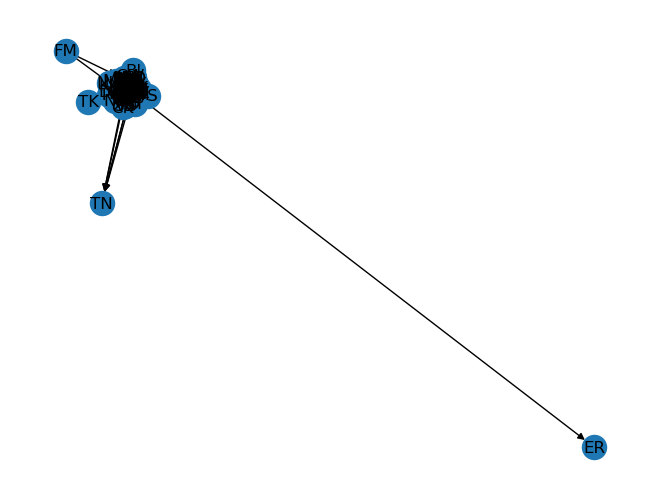

In [23]:
G_plot= G.copy()

# Remove countries without geometry position (only for plotting reasons)
no_geometry = list(country_metadata_filt.loc[country_metadata_filt['pos'].isnull(),'ISO'].values)

G_plot.remove_nodes_from(no_geometry)

country_metadata_filt = country_metadata_filt.loc[~country_metadata_filt.ISO.isin(no_geometry),:]
pos_dict2 = dict(zip(country_metadata_filt.ISO, country_metadata_filt.pos))

# Remove nodes with 0 weight
to_remove = [(u, v, data) for u, v, data in G_plot.edges(data=True) if 'weight' in data and data['weight'] == 0]
G_plot.remove_edges_from(to_remove)

nx.draw(G_plot,pos=nx.spring_layout(G_plot),with_labels=True)

In [24]:
country_metadata_filt = country_metadata_filt.loc[~country_metadata_filt.ISO.isin(no_geometry),:]


The network by itself can be difficult to interpret with a spring layout. Maybe if we place every country on its right position it is easier.

/tmp/ipykernel_3203779/347678596.py:20: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G_plot,pos=pos_dict2,node_size=10, width= weight, arrows=True, min_source_margin=0, min_target_margin=0.1,


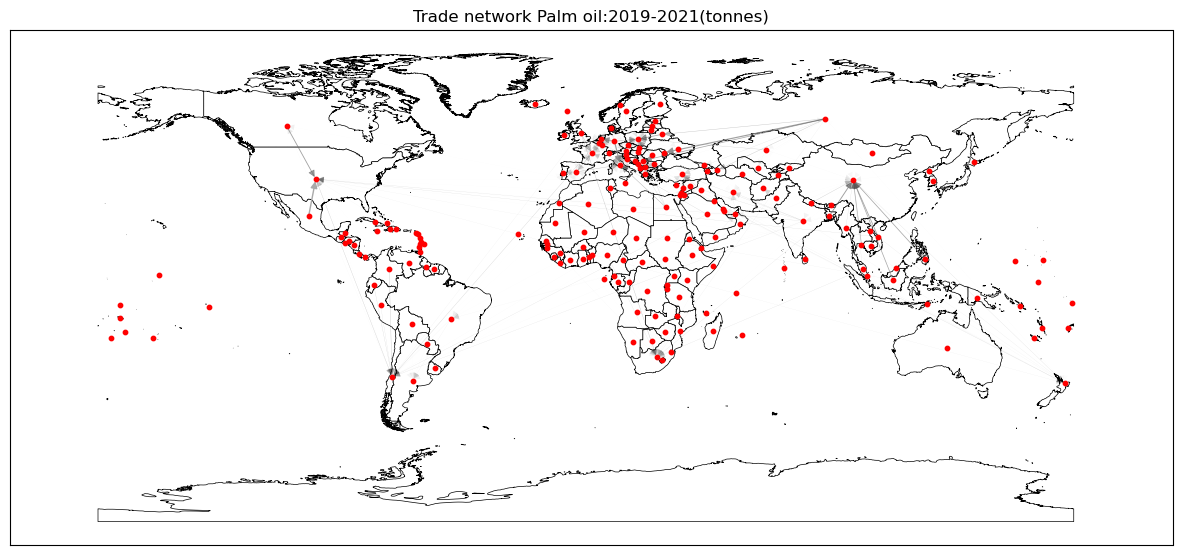

In [27]:
from matplotlib.colors import LinearSegmentedColormap

# Plot in map form: 
node_positions = {node: G_plot.nodes[node]['pos'] for node in G_plot.nodes}
edge_values = [G_plot.edges[edge]['weight'] for edge in G_plot.edges]

# Get edge weights 
#weight= np.log10(edge_values)
weight= edge_values
weight= weight/max(weight)
weight[weight<0]=0

plot_prova = shape_file.plot(figsize=(15, 10),facecolor='white',edgecolor='black', linewidth=0.5)

# Colors
colors = [(0, 0, 0, 0), 'darkgrey']
n_bins = 500  # Number of bins in the colormap
cmap_name = "custom_cmap"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
nx.draw_networkx_edges(G_plot,pos=pos_dict2,node_size=10, width= weight, arrows=True, min_source_margin=0, min_target_margin=0.1,
                       edge_color=weight,edge_cmap=custom_cmap, alpha=weight, ax=plot_prova)
nx.draw_networkx_nodes(G_plot, pos=pos_dict2,node_size=10,alpha=1.0,node_color='red',ax=plot_prova)#draw nodes
plt.title('Trade network Palm oil:'+ str(year)+'(tonnes)')
plt.show()

Text(0.5, 0, 'values')

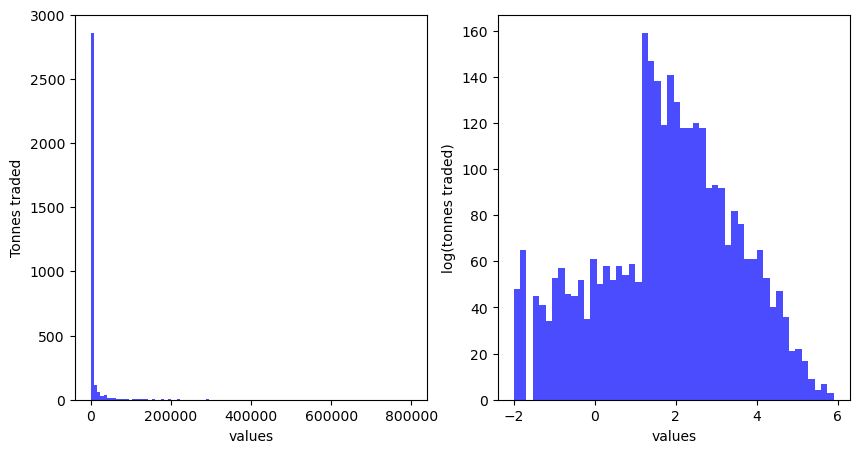

In [26]:
# Distribution of values : 
fig, axs= plt.subplots(1,2,figsize=(10,5))
log_values =np.log10(edge_values)
axs[0].hist(edge_values, bins=100, color='blue', alpha=0.7)
axs[0].set_ylabel('Tonnes traded')
axs[0].set_xlabel('values')

axs[1].hist(log_values, bins=50, color='blue', alpha=0.7)
plt.ylabel('log(tonnes traded)')
plt.xlabel('values')

# Eigenvector centrality (Test)
Eigenvector centrality test for one product. 

Text(0.5, 1.0, 'Relavance countries Palm oil: 2019-2021 (tonnes)')

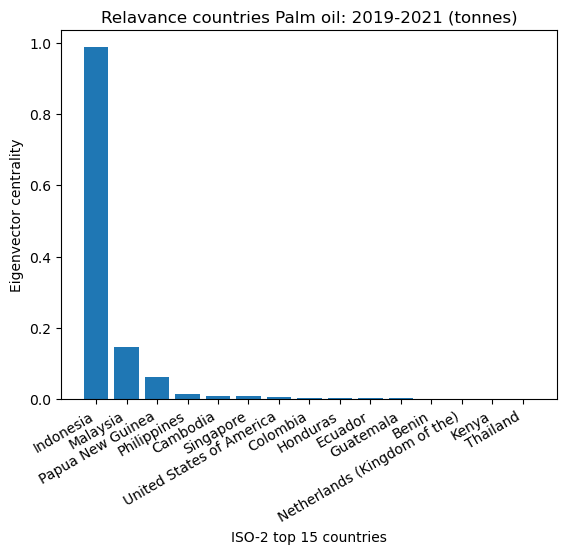

In [12]:
eigv_cent =nx.eigenvector_centrality_numpy(G, weight='weight')
nx.set_node_attributes(G, eigv_cent,name='eigv_c')

country_df=pd.DataFrame(nx.get_node_attributes(G,'name').items(), columns= ['country','name'])
eigv_cent = pd.DataFrame(list(eigv_cent.items()), columns=['country', 'eig_c']).sort_values(by='eig_c',ascending=False).reset_index()
eigv_cent= pd.merge(eigv_cent,country_df, on ='country')

top_n = 15
plt.bar(eigv_cent.loc[range(top_n),'name'],eigv_cent.loc[range(top_n),'eig_c'])
plt.xticks(rotation=30,ha='right')
plt.xlabel('ISO-2 top '+str(top_n)+' countries')
plt.ylabel('Eigenvector centrality')
plt.title('Relavance countries '+ product +': '+ str(year)+' (tonnes)')

Related to bigest importers.

# Page rank (test)
Eigenvector centrality seems to pick the main buyers of palm oil in the system. What about page rank centrality?

Text(0.5, 1.0, 'Relavance countries Palm oil: 2019-2021 (tonnes)')

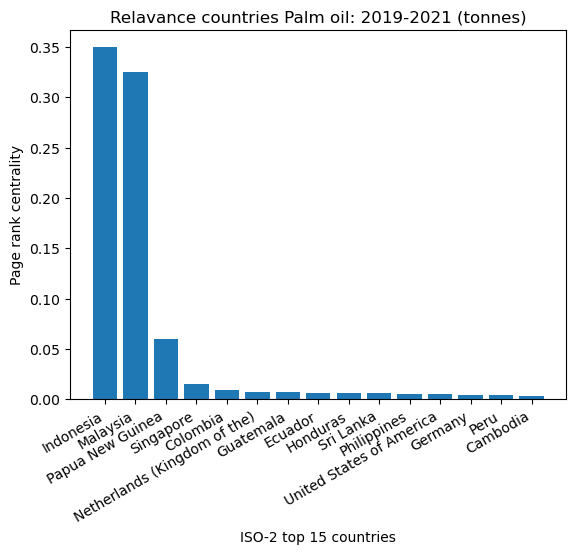

In [13]:
page_cent= nx.pagerank(G,weight='weight')
page_cent = pd.DataFrame(list(page_cent.items()), columns=['country', 'page_c']).sort_values(by='page_c',ascending=False).reset_index()
page_cent= pd.merge(page_cent,country_df, on ='country')

plt.bar(page_cent.loc[range(top_n),'name'],page_cent.loc[range(top_n),'page_c'])
plt.xticks(rotation=30,ha='right')
plt.xlabel('ISO-2 top '+str(top_n)+' countries')
plt.ylabel('Page rank centrality')
plt.title('Relavance countries '+ product +': '+ str(year)+' (tonnes)')

## Degree centrality
In-degree centrality and out-degree centrality

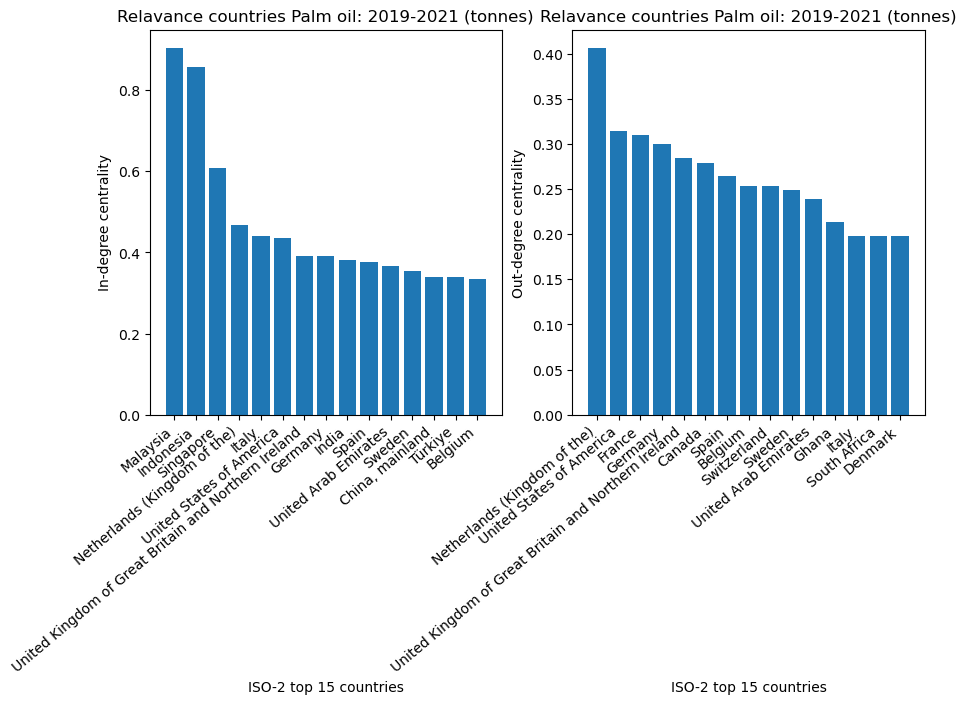

In [14]:
in_deg_cent = nx.in_degree_centrality(G)
nx.set_node_attributes(G, in_deg_cent,name='in_deg_c')

out_deg_cent = nx.out_degree_centrality(G)
nx.set_node_attributes(G, out_deg_cent,name='out_deg_c')

in_deg_cent = pd.DataFrame(list(in_deg_cent.items()), columns=['country', 'in_deg_c']).sort_values(by='in_deg_c',ascending=False).reset_index()
in_deg_cent= pd.merge(in_deg_cent,country_df, on ='country')

out_deg_cent = pd.DataFrame(list(out_deg_cent.items()), columns=['country', 'out_deg_c']).sort_values(by='out_deg_c',ascending=False).reset_index()
out_deg_cent= pd.merge(out_deg_cent,country_df, on ='country')

fig, axes= plt.subplots(1,2,figsize=(10,5))
axes[0].bar(in_deg_cent.loc[range(top_n),'name'],in_deg_cent.loc[range(top_n),'in_deg_c'])
axes[0].set_xticks(axes[0].get_xticks(),axes[0].get_xticklabels(),rotation=40,ha='right')
axes[0].set_xlabel('ISO-2 top '+str(top_n)+' countries')
axes[0].set_ylabel('In-degree centrality')
axes[0].title.set_text('Relavance countries '+ product +': '+ str(year)+' (tonnes)')


axes[1].bar(out_deg_cent.loc[range(top_n),'name'],out_deg_cent.loc[range(top_n),'out_deg_c'])
axes[1].set_xticks(axes[1].get_xticks(),axes[1].get_xticklabels(),rotation=40,ha='right')
axes[1].set_xlabel('ISO-2 top '+str(top_n)+' countries')
axes[1].set_ylabel('Out-degree centrality')
axes[1].title.set_text('Relavance countries '+ product +': '+ str(year)+' (tonnes)')

# Closeness centrality

Text(0.5, 1.0, 'Relavance countries Palm oil: 2019-2021 (tonnes)')

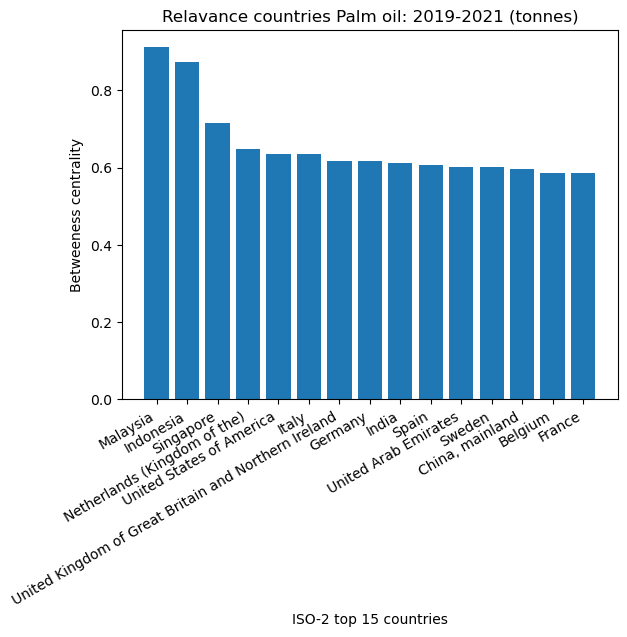

In [15]:
betw_cent= nx.closeness_centrality(G)
betw_cent = pd.DataFrame(list(betw_cent.items()), columns=['country', 'page_c']).sort_values(by='page_c',ascending=False).reset_index()
betw_cent= pd.merge(betw_cent,country_df, on ='country')

plt.bar(betw_cent.loc[range(top_n),'name'],betw_cent.loc[range(top_n),'page_c'])
plt.xticks(rotation=30,ha='right')
plt. xlabel('ISO-2 top '+str(top_n)+' countries')
plt. ylabel('Betweeness centrality')
plt.title('Relavance countries '+ product +': '+ str(year)+' (tonnes)')

# Laplacian centrality

Text(0.5, 1.0, 'Relavance countries Palm oil: 2019-2021 (tonnes)')

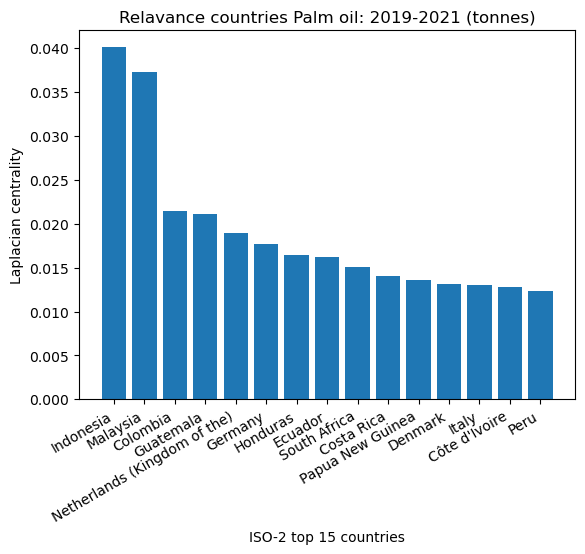

In [16]:
lap_cent= nx.laplacian_centrality(G,weight='weight')
lap_cent = pd.DataFrame(list(lap_cent.items()), columns=['country', 'page_c']).sort_values(by='page_c',ascending=False).reset_index()
lap_cent= pd.merge(lap_cent,country_df, on ='country')

plt.bar(lap_cent.loc[range(top_n),'name'],lap_cent.loc[range(top_n),'page_c'])
plt.xticks(rotation=30,ha='right')
plt. xlabel('ISO-2 top '+str(top_n)+' countries')
plt. ylabel('Laplacian centrality')
plt.title('Relavance countries '+ product +': '+ str(year)+' (tonnes)')